In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,auc,classification_report,confusion_matrix,roc_curve

# Soru 1:
Using the dataset for the risk of heart attack with class imbalance:

* Create a logistic regression model and measure the performance of it.
* By experimenting with different methods and class ratios; overcome class imbalance, determine the best performing method and class ratio.

In [2]:
df=pd.read_csv('cleveland.dat',header=None, sep=',', engine='python')
df.columns=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,negative
1,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,negative
2,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,negative
3,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,negative
4,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,negative


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
age         177 non-null float64
sex         177 non-null float64
cp          177 non-null float64
trestbps    177 non-null float64
chol        177 non-null float64
fbs         177 non-null float64
restecg     177 non-null float64
thalach     177 non-null float64
exang       177 non-null float64
oldpeak     177 non-null float64
slope       177 non-null float64
ca          177 non-null float64
thal        177 non-null float64
num         177 non-null uint8
dtypes: float64(13), uint8(1)
memory usage: 18.2 KB


In [42]:
# Object tipteki "thal" ve "ca" kolonların veri tipi dönüşümünü gerçekleştirelim.

df.thal.replace("<null>", float(3))
df.thal=df.thal.astype("float", inplace=True)

df.ca=df.ca.replace("<null>", float(df.ca.mode()))
df.ca=df.ca.astype("float", inplace=True)

negative    164
positive     13
Name: num, dtype: int64

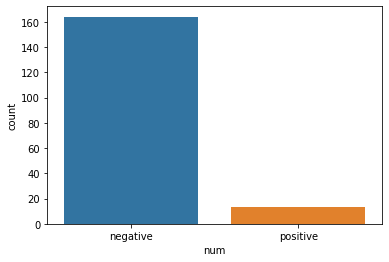

In [3]:
sns.countplot(df.num)
df.num.value_counts()

# 164' e 13 oranında olduğu için imbalanced data olduğunu anlıyoruz.

In [4]:
df["num"]=pd.get_dummies(df["num"], drop_first=True)

In [4]:
df.head(3)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
2,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [45]:
Y=df.num
X=df.iloc[:,0:13]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=42)

log_reg=linear_model.LogisticRegression(solver='liblinear')
log_reg.fit(X_train,Y_train)

y_train_pred=log_reg.predict(X_train)
y_test_pred=log_reg.predict(X_test)


In [46]:
print("Accuracy of train set:", log_reg.score(X_train,Y_train))
print("Accuracy of test set:", log_reg.score(X_test,Y_test))

# Negatif datanın çok olduğu hedef değişken tahmininin doğruluğu çok yüksektir.

Accuracy of train set: 0.9716312056737588
Accuracy of test set: 0.9166666666666666


In [48]:
confusion_test=confusion_matrix(Y_test,y_test_pred)
confusion_train=confusion_matrix(Y_train,y_train_pred)

print("Confusion matrix of train set: ", "\n", confusion_train)
print("Confusion matrix of test set: ", "\n", confusion_test)

Confusion matrix of train set:  
 [[130   1]
 [  3   7]]
Confusion matrix of test set:  
 [[32  1]
 [ 2  1]]


#### 1) Resample (Increased)

In [87]:
from sklearn.utils import resample

negative=df[df.num==0]
positive=df[df.num==1]

increased_positive=resample(positive, replace=True,n_samples=len(negative),random_state=111)

increased_df=pd.concat([negative,positive])
increased_df.num.value_counts()


0    164
1     13
Name: num, dtype: int64

In [80]:
decreased_negative=resample(negative, replace=True, n_samples=len(positive), random_state=111)

decreased_df=pd.concat([negative,positive], ignore_index=True)
decreased_df.num.value_counts()

0    164
1     13
Name: num, dtype: int64

#### 2) SMOTE

In [88]:
from imblearn.over_sampling import SMOTE

In [94]:
Y=df.num
X=df.iloc[:,0:13]

sm=SMOTE(random_state=27, sampling_strategy=1.0)
X_smote, Y_smote= sm.fit_sample(X,Y)

print("Accuracy of smote: ", log_reg.score(X_smote,Y_smote))

# SMOTE veri dengeleme yöntemi kullanılarak doğruluk oranı düşmüştür.

print("Confusion matric of smote:", confusion_matrix)

Accuracy of smote:  0.8536585365853658


#### 3) ADASYN

In [96]:
from imblearn.over_sampling import ADASYN

Y=df.num
X=df.iloc[:,0:13]

ad=ADASYN()
X_adasyn, Y_adasyn = ad.fit_sample(X,Y)

print("Accuracy of adasyn: ", log_reg.score(X_adasyn,Y_adasyn))

# SMOTE data dengeleme yönteminde doğruluk oranı biraz düşmüştür.

Accuracy of adasyn:  0.8480243161094225
